Analyzing: Normal - Front
Analyzing: Bearing Fault - Front
Analyzing: Unbalance - Front
Analyzing: Normal - Angle
Analyzing: Bearing Fault - Angle
Analyzing: Unbalance - Angle


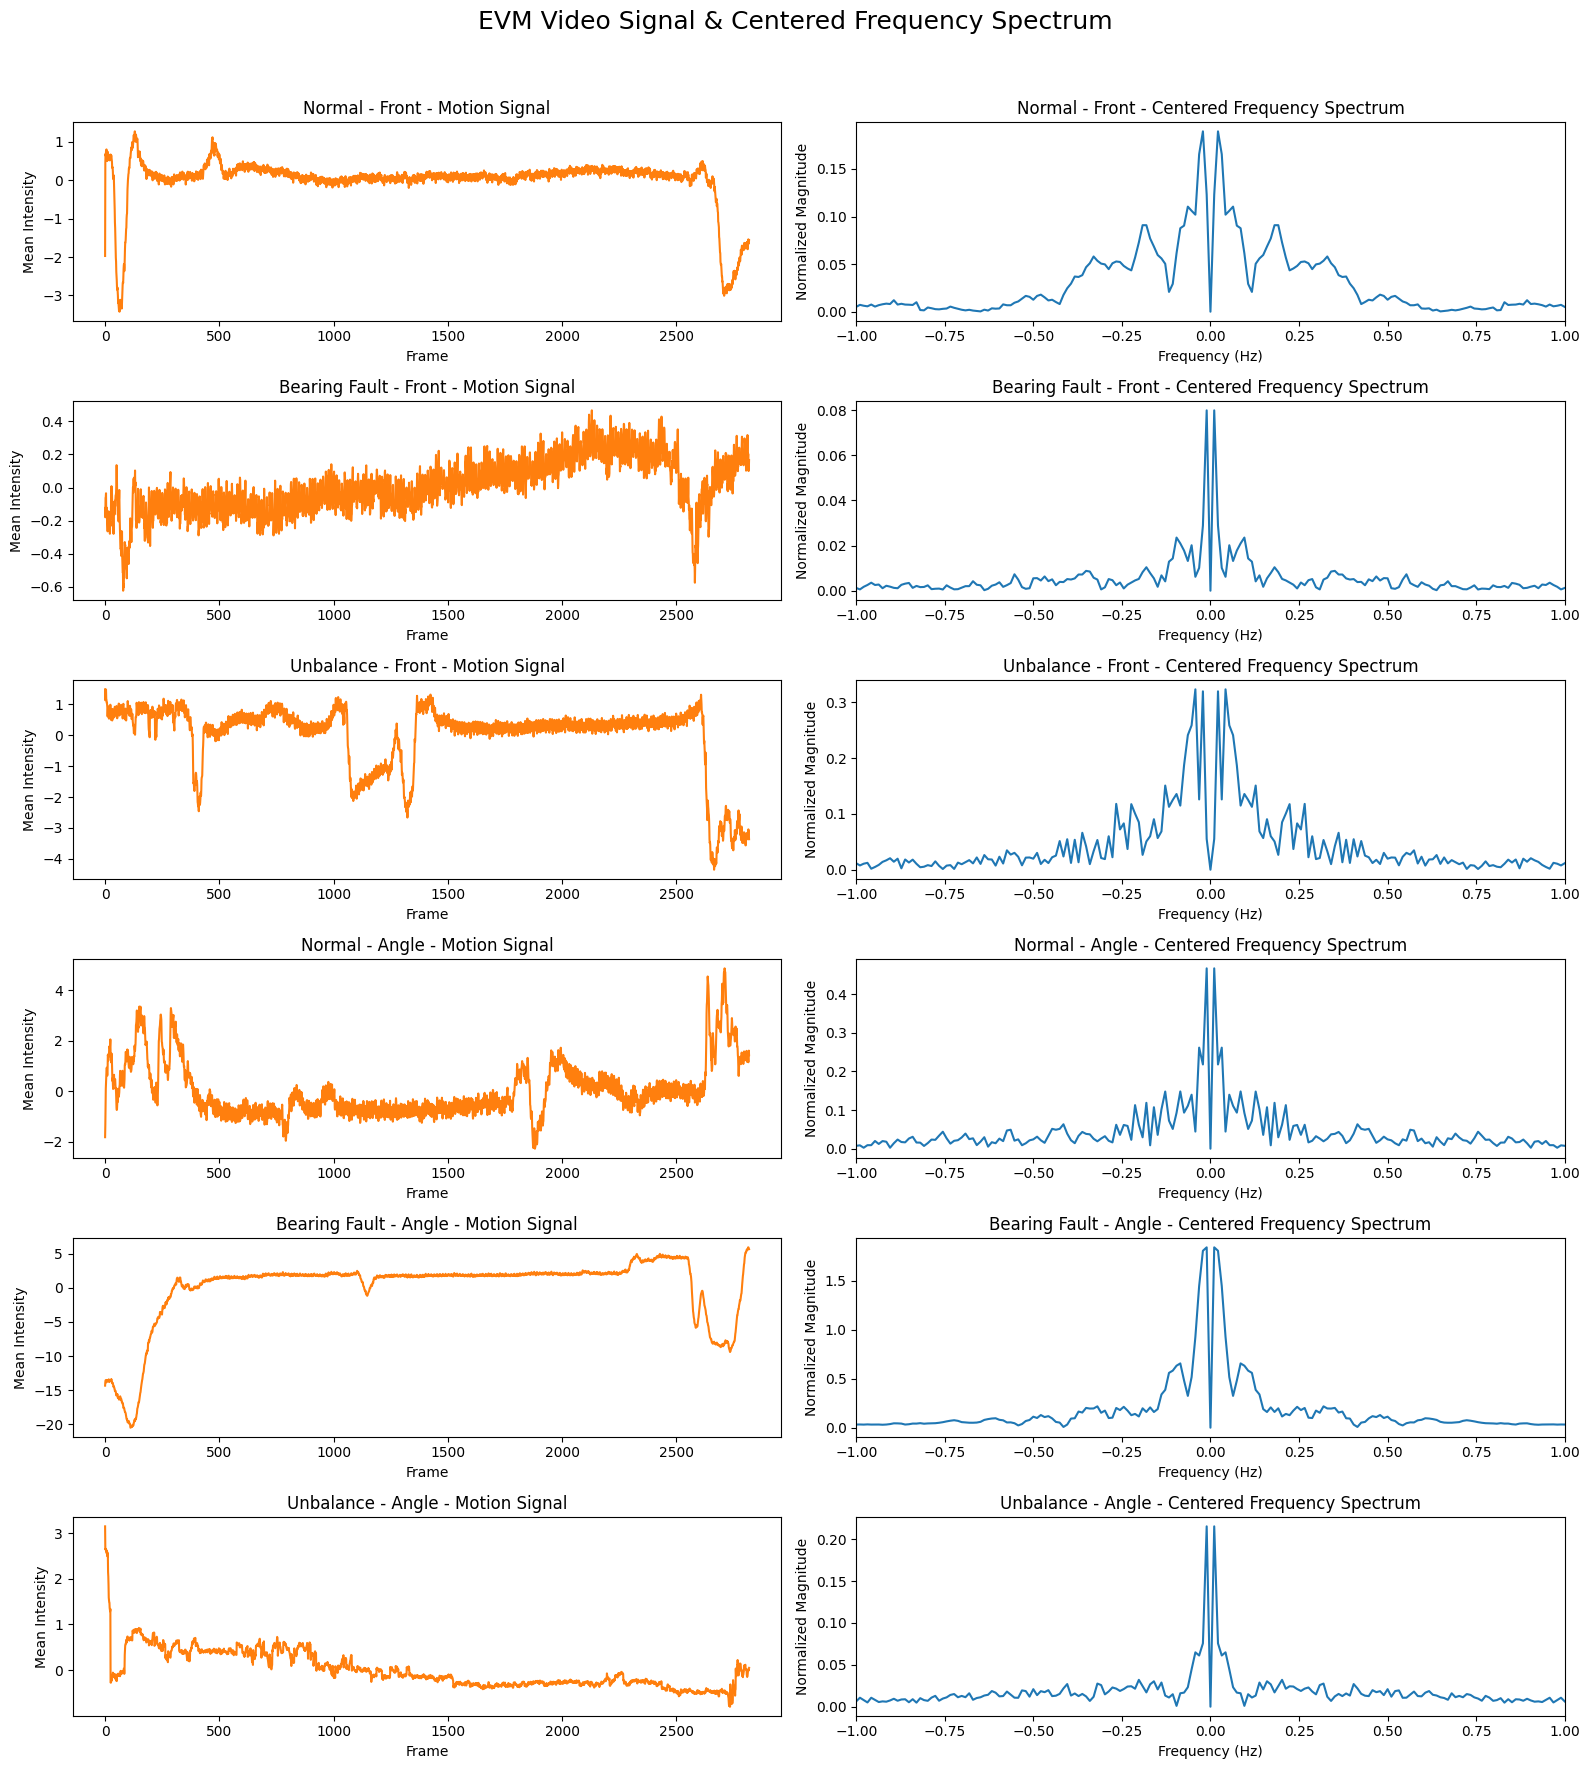

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift

def extract_signal(video_path, fps=30, region=None):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    signals = []

    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if region:
            x, y, w, h = region
            patch = frame[y:y+h, x:x+w, 1]  # green channel
        else:
            patch = frame[..., 1]
        signals.append(np.mean(patch))

    cap.release()
    signal = np.array(signals)

    # Remove DC component
    signal -= np.mean(signal)

    # FFT and center it
    N = len(signal)
    freqs = fftfreq(N, d=1.0/fps)
    spectrum = np.abs(fft(signal)) / N
    centered_freqs = fftshift(freqs)
    centered_spectrum = fftshift(spectrum)

    return signal, centered_freqs, centered_spectrum

# === EVM-processed video paths ===
evm_videos = {
    "Normal - Front": "evm_videos/Normal_state/front_evm.avi",
    "Bearing Fault - Front": "evm_videos/Bearing_fault/front_evm.avi",
    "Unbalance - Front": "evm_videos/Unbalance_weight/front_evm.avi",
    "Normal - Angle": "evm_videos/Normal_state/angle_evm.avi",
    "Bearing Fault - Angle": "evm_videos/Bearing_fault/angle_evm.avi",
    "Unbalance - Angle": "evm_videos/Unbalance_weight/angle_evm.avi",
}

# === Analyze each video ===
results = {}
for label, path in evm_videos.items():
    print(f"Analyzing: {label}")
    signal, freqs, spectrum = extract_signal(path, fps=30)
    results[label] = (signal, freqs, spectrum)

# === Plotting ===
fig, axes = plt.subplots(len(results), 2, figsize=(16, 18))
fig.suptitle("EVM Video Signal & Centered Frequency Spectrum", fontsize=18)

for i, (label, (signal, freqs, spectrum)) in enumerate(results.items()):
    axes[i][0].plot(signal, color='tab:orange')
    axes[i][0].set_title(f"{label} - Motion Signal")
    axes[i][0].set_xlabel("Frame")
    axes[i][0].set_ylabel("Mean Intensity")

    axes[i][1].plot(freqs, spectrum, color='tab:blue')
    axes[i][1].set_title(f"{label} - Centered Frequency Spectrum")
    axes[i][1].set_xlim(-1, 1)  # Show from -10 Hz to +10 Hz
    axes[i][1].set_xlabel("Frequency (Hz)")
    axes[i][1].set_ylabel("Normalized Magnitude")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
